# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Randomly show 30 of train dataset


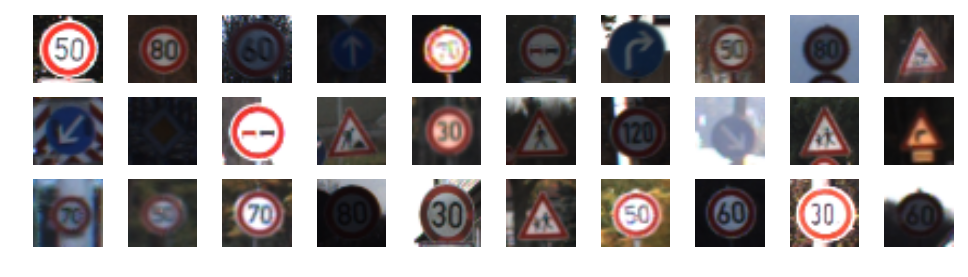

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

# Randomly show 30 of train dataset
print('Randomly show 30 of train dataset')

plt.figure(figsize=(12,3))
for i in range(30):
    plt.subplot(3,10,i+1)
    random = np.random.randint(0, n_train)
    image = X_train[random].squeeze()
    plt.axis('off')
    plt.imshow(image)

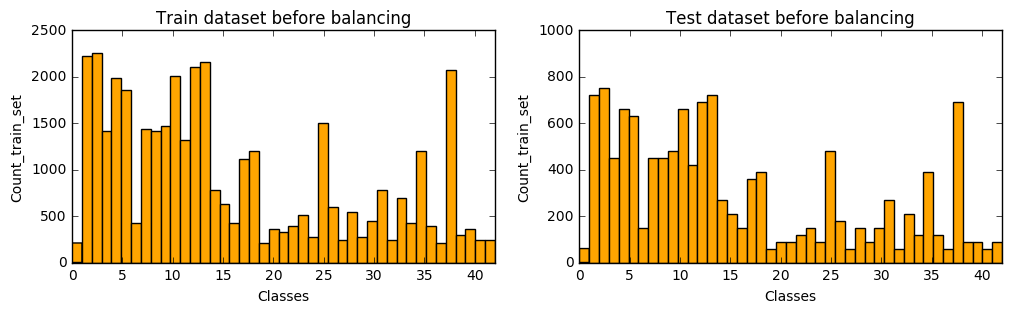

In [4]:
# Each classes' train dataset size
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.axis([0, 42, 0, 2500])
plt.hist(y_train, n_classes,color='orange')
plt.title('Train dataset before balancing')
plt.xlabel('Classes')
plt.ylabel('Count_train_set')

# Each classes' test dataset size
plt.subplot(1,2,2)
plt.axis([0, 42, 0, 1000])
plt.hist(y_test, n_classes,color='orange')
plt.title('Test dataset before balancing')
plt.xlabel('Classes')
plt.ylabel('Count_train_set')

plt.show()

## Preprocessing


**1. Dataset balancing**
- add transformed images to balance all dataset
- transform method : randomly rotate, warp, Histogram Equalization

**2. Normalization**
- adjusting values measured on different scales to a notionally common scale

**3. Shuffle data**
- The data is sorted by class. Need to be shuffled to avoid any bias. 

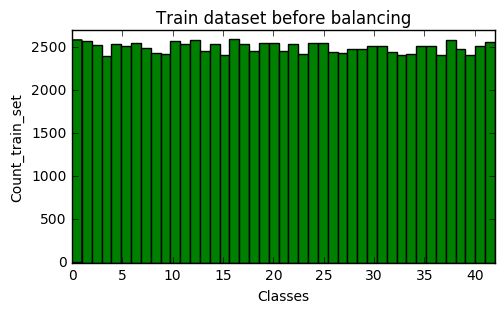

In [5]:
import cv2
import numpy as np

def transform_image(image,rot_angle, trans_range, kernel_size):
    """Applies a random rotation"""
    rows,cols = image.shape[:2]
    rand_ang = np.random.uniform(-rot_angle, rot_angle)
    rot_mat = cv2.getRotationMatrix2D((cols/2, rows/2), rand_ang, 1.0)
    
    """Applies a random translation"""
    tr_x = np.random.uniform(-trans_range, trans_range)
    tr_y = np.random.uniform(-trans_range, trans_range)
    tr_mat = np.float32([[1,0,tr_x],[0,1,tr_y]])
    
    """Applies a Histogram Equalization"""
    switch = np.random.randint(0, 2)
    if switch == 1:
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    #"""Applies a Gaussian Noise kernel"""
    #k_size = np.random.randint(0, kernel_size)*2+1 # 1 or 3 or 5
    #blur_img = cv2.GaussianBlur(image,(k_size, k_size), 0)
    
    result = cv2.warpAffine(image , rot_mat, (cols,rows))
    #result = cv2.warpAffine(result, tr_mat, (cols,rows))
    
    return result

class_bincount = np.bincount(y_train)

for i in range(n_classes):     
    new_features, new_labels = [], []
    features = X_train[np.where(y_train == i)]
    add_count = 2500 - class_bincount[i] + np.random.randint(-100, 100) # the number of adding images
    for j in range(add_count):
        rand_img = np.random.randint(class_bincount[i])
        new_features.append(transform_image(features[rand_img],3,1,3))
        new_labels.append(i)
        
    X_train = np.append(X_train, new_features, axis=0)
    y_train = np.append(y_train, new_labels, axis=0)
    
del new_features, new_labels

# Each classes' train dataset size after balancing
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.axis([0, 42, 0, 2700])
plt.hist(y_train, n_classes,color='green')
plt.title('Train dataset before balancing')
plt.xlabel('Classes')
plt.ylabel('Count_train_set')

plt.show()

show 30 of balanced train dataset


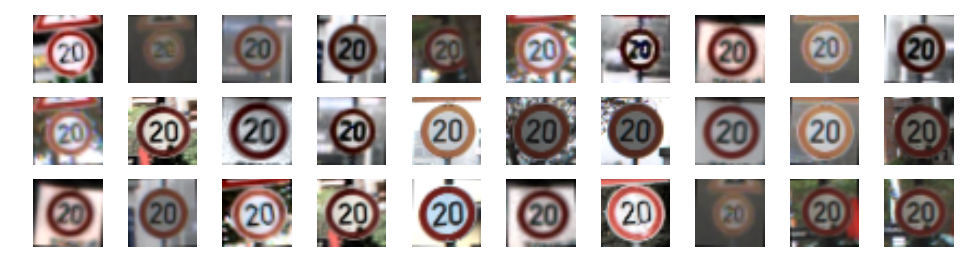

In [6]:
# show 30 of balanced train dataset
print('show 30 of balanced train dataset')

features = X_train[np.where(y_train == 0)]
plt.figure(figsize=(12,3))
for i in range(30):
    plt.subplot(3,10,i+1)
    random = np.random.randint(0, n_train)
    image = features[np.random.randint(0, 2400)]
    plt.axis('off')
    plt.imshow(image)


In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# shuffle the train dataset
X_train, y_train = shuffle(X_train, y_train)

# split data into training and validation set (80 : 20)
X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(X_train,y_train,test_size=0.2, 
                                                                      random_state = np.random.randint(0, len(X_train)))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

*1. Dataset balancing*
- add transformed images to balance all dataset

*2. Normalization*
- adjusting values measured on different scales to a notionally common scale
I 
*3. Shuffle data*
- The data is sorted by class. Need to be shuffled to avoid any bias.

-> Finally I decided not to use normalization(0, 255 -> 0, 1) and didn't use translation when make an additional test image.
There were no effect of normalization(0, 255 -> 0, 1) because already all image's value range is same.
Also I skipped tralated image because I expected robust training dataset but contrary to expectations, it gave me low accracy.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I split the data into training(80%) and validation(20%) sets using the train_test_split function of sklearn. 
Test my NN using validation set for each epoch.

I generated additional data to keep the balance between classes. 
My transform method is randomly rotating(-3~3), Histogram Equalization(randomly). At first, I warpped image(-5~5) and ratate range was -20 ~ 20. But it brought worse accuracy.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 256

with tf.name_scope('weight'):
    normal_weights = {
        'w_conv1': tf.Variable(tf.random_normal([3, 3, 3, 16]),name='w_conv1_normal'),
        'w_conv2': tf.Variable(tf.random_normal([3, 3, 16, 16]),name='w_conv2_normal'),
        'w_conv3': tf.Variable(tf.random_normal([3, 3, 16, 64]),name='w_conv3_normal'),
        'w_conv4': tf.Variable(tf.random_normal([3, 3, 64, 64]),name='w_conv4_normal'),
        'w_conv5': tf.Variable(tf.random_normal([3, 3, 64, 128]),name='w_conv5_normal'),
        'w_conv6': tf.Variable(tf.random_normal([3, 3, 128, 128]),name='w_conv6_normal'),
        'w_conv7': tf.Variable(tf.random_normal([3, 3, 128, 128]),name='w_conv7_normal'),
        'w_conv8': tf.Variable(tf.random_normal([3, 3, 128, 128]),name='w_conv8_normal'),
        'w_fc1': tf.Variable(tf.random_normal([1152, 512]),name='w_fc1_normal'),
        'w_fc2': tf.Variable(tf.random_normal([512, 256]),name='w_fc2_normal'),
        'w_fc3': tf.Variable(tf.random_normal([256, 43]),name='w_fc3_normal')
    }
    truncated_normal_weights  = {
        'w_conv1': tf.Variable(tf.truncated_normal([3, 3, 3, 16],stddev=0.1),name='w_conv1_truncated_normal'),
        'w_conv2': tf.Variable(tf.truncated_normal([3, 3, 16, 16],stddev=0.1),name='w_conv2_truncated_normal'),
        'w_conv3': tf.Variable(tf.truncated_normal([3, 3, 16, 64],stddev=0.1),name='w_conv3_truncated_normal'),
        'w_conv4': tf.Variable(tf.truncated_normal([3, 3, 64, 64],stddev=0.1),name='w_conv4_truncated_normal'),
        'w_conv5': tf.Variable(tf.truncated_normal([3, 3, 64, 128],stddev=0.1),name='w_conv5_truncated_normal'),
        'w_conv6': tf.Variable(tf.truncated_normal([3, 3, 128, 128],stddev=0.1),name='w_conv6_truncated_normal'),
        'w_conv7': tf.Variable(tf.truncated_normal([3, 3, 128, 128],stddev=0.1),name='w_conv7_truncated_normal'),
        'w_conv8': tf.Variable(tf.truncated_normal([3, 3, 128, 128],stddev=0.1),name='w_conv8_truncated_normal'),
        'w_fc1': tf.Variable(tf.truncated_normal([1152, 512],stddev=0.1),name='w_fc1_truncated_normal'),
        'w_fc2': tf.Variable(tf.truncated_normal([512, 256],stddev=0.1),name='w_fc2_truncated_normal'),
        'w_fc3': tf.Variable(tf.truncated_normal([256, 43],stddev=0.1),name='w_fc3_truncated_normal')
    }
    xavier_weights  = {
        'w_conv1': tf.get_variable('w_conv1_xaiver', [3, 3, 3, 16],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv2': tf.get_variable('w_conv2_xaiver', [3, 3, 16, 16],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv3': tf.get_variable('w_conv3_xaiver', [3, 3, 16, 64],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv4': tf.get_variable('w_conv4_xaiver', [3, 3, 64, 64],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv5': tf.get_variable('w_conv5_xaiver', [3, 3, 64, 128],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv6': tf.get_variable('w_conv6_xaiver', [3, 3, 128, 128],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv7': tf.get_variable('w_conv7_xaiver', [3, 3, 128, 128],initializer=tf.contrib.layers.xavier_initializer()),
        'w_conv8': tf.get_variable('w_conv8_xaiver', [3, 3, 128, 128],initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc1': tf.get_variable('w_fc1_xaiver', [1152, 512],initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc2': tf.get_variable('w_fc2_xaiver', [512, 256],initializer=tf.contrib.layers.xavier_initializer()),
        'w_fc3': tf.get_variable('w_fc3_xaiver', [256, 43],initializer=tf.contrib.layers.xavier_initializer())
    }

    he_weights = {
        'w_conv1': tf.get_variable('w_conv1_he', [3, 3, 3, 16],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv2': tf.get_variable('w_conv2_he', [3, 3, 16, 16],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv3': tf.get_variable('w_conv3_he', [3, 3, 16, 64],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv4': tf.get_variable('w_conv4_he', [3, 3, 64, 64],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv5': tf.get_variable('w_conv5_he', [3, 3, 64, 128],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv6': tf.get_variable('w_conv6_he', [3, 3, 128, 128],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv7': tf.get_variable('w_conv7_he', [3, 3, 128, 128],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_conv8': tf.get_variable('w_conv8_he', [3, 3, 128, 128],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_fc1': tf.get_variable('w_fc1_he', [1152, 512],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_fc2': tf.get_variable('w_fc2_he', [512, 256],initializer=tf.contrib.layers.variance_scaling_initializer()),
        'w_fc3': tf.get_variable('w_fc3_he', [256, 43],initializer=tf.contrib.layers.variance_scaling_initializer())
    }

with tf.name_scope('bias'):
    normal_biases = {
        'b_conv1': tf.Variable(tf.random_normal([16]),name='b_conv1_normal'),
        'b_conv2': tf.Variable(tf.random_normal([16]),name='b_conv2_normal'),
        'b_conv3': tf.Variable(tf.random_normal([64]),name='b_conv3_normal'),
        'b_conv4': tf.Variable(tf.random_normal([64]),name='b_conv4_normal'),
        'b_conv5': tf.Variable(tf.random_normal([128]),name='b_conv5_normal'),
        'b_conv6': tf.Variable(tf.random_normal([128]),name='b_conv6_normal'),
        'b_conv7': tf.Variable(tf.random_normal([128]),name='b_conv7_normal'),
        'b_conv8': tf.Variable(tf.random_normal([128]),name='b_conv8_normal'),
        'bfc1': tf.Variable(tf.random_normal([512]),name='b_fc1_normal'),
        'bfc2': tf.Variable(tf.random_normal([256]),name='b_fc2_normal'),
        'bfc3': tf.Variable(tf.random_normal([43]),name='b_fc3_normal')
    }
    zero_biases = {
        'b_conv1': tf.Variable(tf.zeros([16]),name='b_conv1_zero'),
        'b_conv2': tf.Variable(tf.zeros([16]),name='b_conv2_zero'),
        'b_conv3': tf.Variable(tf.zeros([64]),name='b_conv3_zero'),
        'b_conv4': tf.Variable(tf.zeros([64]),name='b_conv4_zero'),
        'b_conv5': tf.Variable(tf.zeros([128]),name='b_conv5_zero'),
        'b_conv6': tf.Variable(tf.zeros([128]),name='b_conv6_zero'),
        'b_conv7': tf.Variable(tf.zeros([128]),name='b_conv7_zero'),
        'b_conv8': tf.Variable(tf.zeros([128]),name='b_conv8_zero'),
        'b_fc1': tf.Variable(tf.zeros([512]),name='b_fc1_zero'),
        'b_fc2': tf.Variable(tf.zeros([256]),name='b_fc2_zero'),
        'b_fc3': tf.Variable(tf.zeros([43]),name='b_fc3_zero')
    }      
    
weight_initializer = {'normal':normal_weights, 'truncated_normal':truncated_normal_weights, 'xavier':xavier_weights, 'he':he_weights}
bias_initializer = {'normal':normal_biases, 'zero':zero_biases}

weight_init = 'xavier' # 'normal' or 'truncated_normal' or 'xavier' or 'he'
bias_init = 'zero' # 'normal' or 'zero'

weights = weight_initializer[weight_init]
biases = bias_initializer[bias_init]

In [1]:
def Conv_layer(in_layer, weight, bias, pad='SAME', pooling=False, is_training=True, reuse=False):
    
    """ weight init : he_init , bias_init : zero """
    out_layer = tf.nn.conv2d(in_layer, weight, strides=[1, 1, 1, 1], padding=pad) #+ bias

    """ using Batch Normalization """
    out_layer = tf.contrib.layers.batch_norm(out_layer, is_training=is_training,
                    center=True, scale=True, activation_fn=tf.nn.relu, trainable=True, decay=0.9, updates_collections=None, reuse = reuse)
    """ activation func : Relu """
    out_layer = tf.nn.relu(out_layer)

    if pooling==True:
        """ Pooling method : Max Pooling """
        out_layer = tf.nn.max_pool(out_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    return out_layer

def FC_layer(in_layer, weight, bias, is_training=True, reuse=False):
    
    """ weight init : he_init , bias_init : zero """
    out_layer   = tf.matmul(in_layer, weight) #+  bias

    """ using Batch Normalization """
    out_layer = tf.contrib.layers.batch_norm(out_layer, is_training=is_training,
                    center=True, scale=True, activation_fn=tf.nn.relu, trainable=True, decay=0.9, updates_collections=None, reuse = reuse)
    """ activation func : Relu """
    out_layer    = tf.nn.relu(out_layer)
    
    return out_layer

In [2]:
def Traffic_Net(x, is_training=True, reuse=False):

    # Input = 32x32x3 -> Conv1 = 32x32x16
    conv1 = Conv_layer(x, weights['w_conv1'], biases['b_conv1'], pad='SAME', pooling=False, is_training=True, reuse=False)   

    # Conv1 = 32x32x16 -> Conv2 = 32x32x16 -> conv2_Pooling = 16x16x16
    conv2 = Conv_layer(conv1, weights['w_conv2'], biases['b_conv2'], pad='SAME', pooling=True, is_training=True, reuse=False)
    
    # Conv2_Pooling = 16x16x16 -> Conv3 = 16x16x64
    conv3 = Conv_layer(conv2, weights['w_conv3'], biases['b_conv3'], pad='SAME', pooling=False, is_training=True, reuse=False)

    # Conv3 = 16x16x64 -> Conv4 = 16x16x64 -> conv4_Pooling = 8x8x64
    conv4 = Conv_layer(conv3, weights['w_conv4'], biases['b_conv4'], pad='SAME', pooling=True, is_training=True, reuse=False)
    
    # Conv4_Pooling = 8x8x64 -> Conv5 = 8x8x128
    conv5 = Conv_layer(conv4, weights['w_conv5'], biases['b_conv5'], pad='SAME', pooling=False, is_training=True, reuse=False)

    # Conv5 = 8x8x128 -> Conv6 = 6x6x128 -> conv6_Pooling = 3x3x128
    conv6 = Conv_layer(conv5, weights['w_conv6'], biases['b_conv6'], pad='VALID', pooling=True, is_training=True, reuse=False)
    
    # Conv6_Pooling = 3x3x128 -> Conv7 = 3x3x128
    conv7 = Conv_layer(conv6, weights['w_conv7'], biases['b_conv7'], pad='SAME', pooling=False, is_training=True, reuse=False)

    # Conv7 = 3x3x128 -> Conv8 = 3x3x128
    conv8 = Conv_layer(conv7, weights['w_conv8'], biases['b_conv8'], pad='SAME', pooling=False, is_training=True, reuse=False)
    
    # Flatten. 3x3x128 -> 1152
    fc0 = flatten(conv8)

    # FC0 = 1152 -> FC1 = 512
    fc1 = FC_layer(fc0, weights['w_fc1'], biases['b_fc1'], is_training=True, reuse=False)
    
    # FC1 = 512 -> FC2 = 256
    fc2 = FC_layer(fc1, weights['w_fc2'], biases['b_fc2'], is_training=True, reuse=False)
    
    # FC2 = 256 -> FC3 = 43
    logits = tf.matmul(fc2, weights['w_fc3']) + biases['b_fc3']

    L2_loss = (tf.nn.l2_loss(weights['w_conv1']) + tf.nn.l2_loss(weights['w_conv2'])
            + tf.nn.l2_loss(weights['w_conv3']) + tf.nn.l2_loss(weights['w_conv4'])
            + tf.nn.l2_loss(weights['w_conv5']) + tf.nn.l2_loss(weights['w_conv6'])
            + tf.nn.l2_loss(weights['w_conv7']) + tf.nn.l2_loss(weights['w_conv8'])
            + tf.nn.l2_loss(weights['w_fc1']) + tf.nn.l2_loss(weights['w_fc2'])
            + tf.nn.l2_loss(weights['w_fc3']))
    
    return logits, L2_loss

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

my deep leural net architecture is this.

<img src="dnn_arch.png" width="640" alt="Combined Image" />

Convolutional layer 8 and fully connected layer 3 and 3 max-pooling. 

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
# Boolean for MODE of train or test
is_training = tf.placeholder(tf.bool, name='MODE')
reuse = tf.placeholder(tf.bool, name='MODE')
# one_hot_y = tf.one_hot(y, 43)
# To solve a CUDA Error. https://github.com/tensorflow/tensorflow/issues/6509
num_labels = 43
sparse_labels = tf.reshape(y, [-1, 1])
derived_size = tf.shape(sparse_labels)[0]
indices = tf.reshape(tf.range(0, derived_size, 1), [-1, 1])
concated = tf.concat(1, [indices, sparse_labels])
outshape = tf.concat(0, [tf.reshape(derived_size, [1]), tf.reshape(num_labels, [1])])
one_hot_y = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)

rate = 0.001
beta = 0.00001

logits, L2_loss = Traffic_Net(x, is_training=True, reuse=False)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)  + beta * L2_loss

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, is_training:False, reuse:True})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_set)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_set, y_train_set)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training:True, reuse:False})
            
        validation_accuracy = evaluate(X_valid_set, y_valid_set)
        print("EPOCH {} ... Validation Accuracy = {:.3f}".format(i+1,validation_accuracy))
        print()
        
    saver.save(sess, "./lenet.ckpt")
    print("Model saved")

Training...

EPOCH 1 ... Validation Accuracy = 0.988

EPOCH 2 ... Validation Accuracy = 0.993

EPOCH 3 ... Validation Accuracy = 0.993

EPOCH 4 ... Validation Accuracy = 0.998

EPOCH 5 ... Validation Accuracy = 0.994

EPOCH 6 ... Validation Accuracy = 0.997

EPOCH 7 ... Validation Accuracy = 0.999

EPOCH 8 ... Validation Accuracy = 0.992

EPOCH 9 ... Validation Accuracy = 0.998

EPOCH 10 ... Validation Accuracy = 0.997

EPOCH 11 ... Validation Accuracy = 0.999

EPOCH 12 ... Validation Accuracy = 0.996

EPOCH 13 ... Validation Accuracy = 0.999

EPOCH 14 ... Validation Accuracy = 0.999

EPOCH 15 ... Validation Accuracy = 0.997

EPOCH 16 ... Validation Accuracy = 0.997

EPOCH 17 ... Validation Accuracy = 0.997

EPOCH 18 ... Validation Accuracy = 0.999

EPOCH 19 ... Validation Accuracy = 1.000

EPOCH 20 ... Validation Accuracy = 0.996

EPOCH 21 ... Validation Accuracy = 0.998

EPOCH 22 ... Validation Accuracy = 0.999

EPOCH 23 ... Validation Accuracy = 0.995

EPOCH 24 ... Validation Accura

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.978


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

I used AdamOptimizer. It's better than SGD. Batch size is 256 and epoch is 30.
My learning rate is 0.001 and L2 weight regularization's beta value is 0.00001. At first, I tested with 0.001 but I realized low beta value(0.00001) is better. Maybe it's because of batch normalization. I heard that 'if we use batch normalization, reducing l2 weight is more powerful.'

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tested various methods. As a result, to get high accuracy I used batch normalization and he_initialization for effective weight init. I wanted use batch normalization but at first, there were many errors. I had not to train when process testing but I didn't. 

Bias and batch normalization's beta have same work so I didn't use bias learning. And also didn't use dropout because batch normalization already conduct similar work with dropout. I tested my network include dropout but accuracy decreased.

<img src="graph3.png" width="640" alt="Combined Image" />

I tested 4 method about weight initialization. random, truncated random, xavier, he.

Random method's result was really bad but other method's are all good. Among them, he's initialization was best in my test. But the difference was small except random method.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

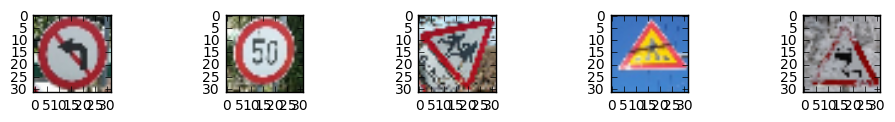

In [15]:
import matplotlib.image as mpimg

new_sign = ['sign1.png', 'sign2.png', 'sign3.png', 'sign4.png', 'sign5.png']
    
test_img = []

for img in new_sign:
    image = mpimg.imread('new_signs/' + img)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    test_img.append(image)    
    
plt.figure(figsize=(12,1))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(test_img[i])


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I added some sign including real environment. For example, a snow-covered sign or a sign with shadow or roughly rotated image.
Also, german traffic sign is not included one of the five candidate images.



New image # 1



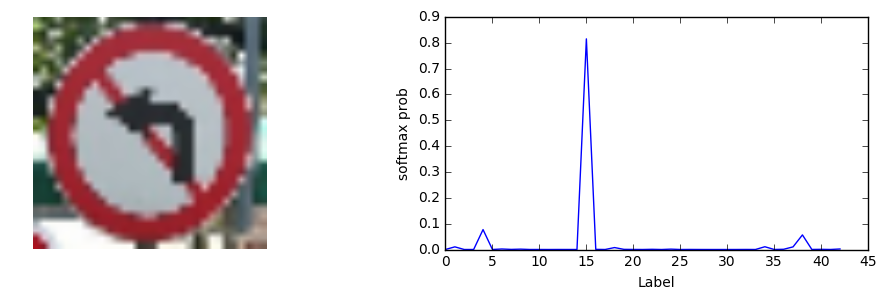


Label : No vehicles         -> acc 82.053%
Label : Speed limit (70km/h)         -> acc 7.340%
Label : Keep right         -> acc 5.584%
Label : Turn left ahead         -> acc 1.055%
Label : Speed limit (30km/h)         -> acc 1.017%


New image # 2



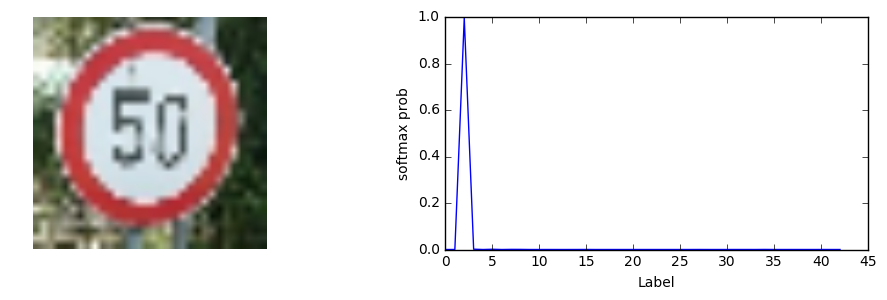


Label : Speed limit (50km/h)         -> acc 99.565%
Label : Speed limit (60km/h)         -> acc 0.125%
Label : Speed limit (80km/h)         -> acc 0.106%
Label : Speed limit (100km/h)         -> acc 0.051%
Label : Speed limit (120km/h)         -> acc 0.044%


New image # 3



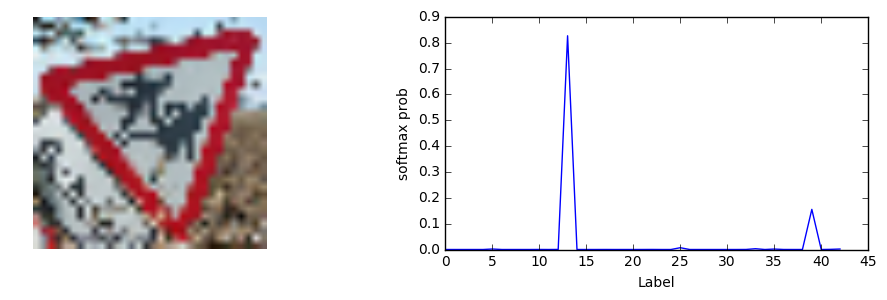


Label : Yield         -> acc 82.555%
Label : Keep left         -> acc 15.667%
Label : Road work         -> acc 0.723%
Label : Turn right ahead         -> acc 0.311%
Label : Speed limit (80km/h)         -> acc 0.192%


New image # 4



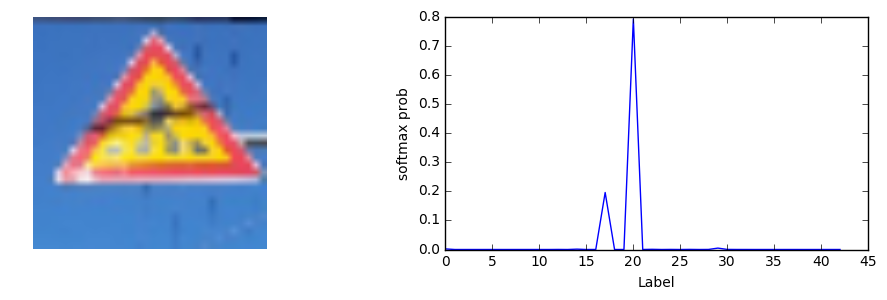


Label : Dangerous curve to the right         -> acc 78.841%
Label : No entry         -> acc 20.150%
Label : Bicycles crossing         -> acc 0.446%
Label : Speed limit (20km/h)         -> acc 0.194%
Label : Stop         -> acc 0.122%


New image # 5



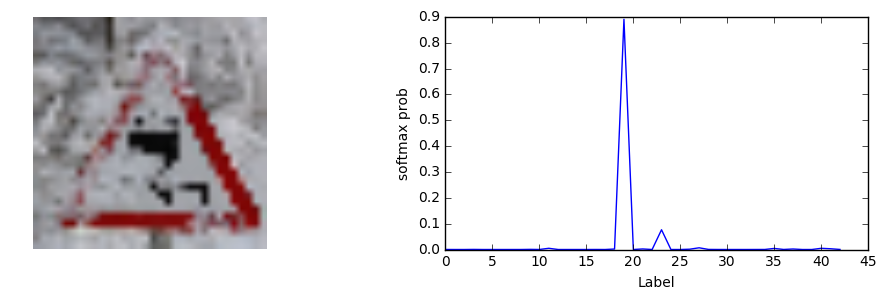


Label : Dangerous curve to the left         -> acc 89.923%
Label : Slippery road         -> acc 6.930%
Label : Pedestrians         -> acc 0.651%
Label : Right-of-way at the next intersection         -> acc 0.449%
Label : Roundabout mandatory         -> acc 0.439%


In [16]:
import csv

softmax = tf.nn.softmax(logits)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    k = 5
    with open('signnames.csv', mode='r') as infile:
        reader = csv.reader(infile)
        s_name = dict((rows[0],rows[1]) for rows in reader)
    
    my_prediction = sess.run(softmax, feed_dict={x:test_img, is_training:False, reuse:True})
    top_k = tf.nn.top_k(softmax, k)

    #output = sess.run(softmax, feed_dict={x: test_img})
    #top3_pred = sess.run(tf.nn.top_k((output), k=3))
    values, indices = sess.run(top_k, feed_dict={x:test_img, is_training:False, reuse:True})

    class_n = []
    for x in range(43):
        class_n.append(x)
        
    for i in range(k):
        print()
        print()
        plt.figure(figsize=(12, 3))
        print("New image #",i+1)
        print()
        plt.subplot(1,2,1)
        plt.imshow(test_img[i])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.plot(class_n, my_prediction[i])
        plt.xlabel('Label')
        plt.ylabel('softmax prob')
        plt.show() 
        
        print()        
        for j in range(k):
            print("Label : {}         -> acc {:.3f}%".format(s_name[str(indices[i,j])], values[i,j] * 100,))  

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

My new test image's accuracy is 20%.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

I tested 5 new images and the result was terrible. Of course, I tested difficult images except one image.(so accuracy is 20%...)

<img src="new_test_result.png" width="640" alt="Combined Image" />

Image1 : wrong result. must be wrong because the sign isn't included in german traffic sign classifier.

Image2 : correct result. easy to classify. (added this image to avoid 0% accuracy.. :p)

Image3 : wrong result. I was curious how robust about rotation this network is but the result was bad. I think the top 1 sign show this algorithm is not rotation invariant. We need additional method to get a rotation invariant result.

Image4 : wrong result. wrong clasify because of shadow. We also need other method to distinguish shadow or eliminate it.

Image5 : wrong result. some parts are hid with snow. Top 2 was correct label.